In [1]:
#
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from gurobipy import *
from scipy.spatial.distance import cdist, euclidean
from scipy.stats import truncnorm
from scipy.sparse import csr_matrix

In [2]:
path = "C:/Users/jp.rodriguezr2/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
#path = "C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
coor = pd.read_csv(path+'MOPTA2023_car_locations.csv', sep = ',', header = None)


In [3]:
stations = pd.read_csv(path+"fuel_stations.csv")

northern = (-79.761960, 42.269385)
southern = (-76.9909,39.7198)
western = (-80.519400, 40.639400)
eastern = (-74.689603, 41.363559)

stations_loc = stations[["Longitude","Latitude"]]
stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53

C:\Users\jp.rodriguezr2\AppData\Local\Temp\ipykernel_8064\3076666102.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
C:\Users\jp.rodriguezr2\AppData\Local\Temp\ipykernel_8064\3076666102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53


48 Out-of-range Stations


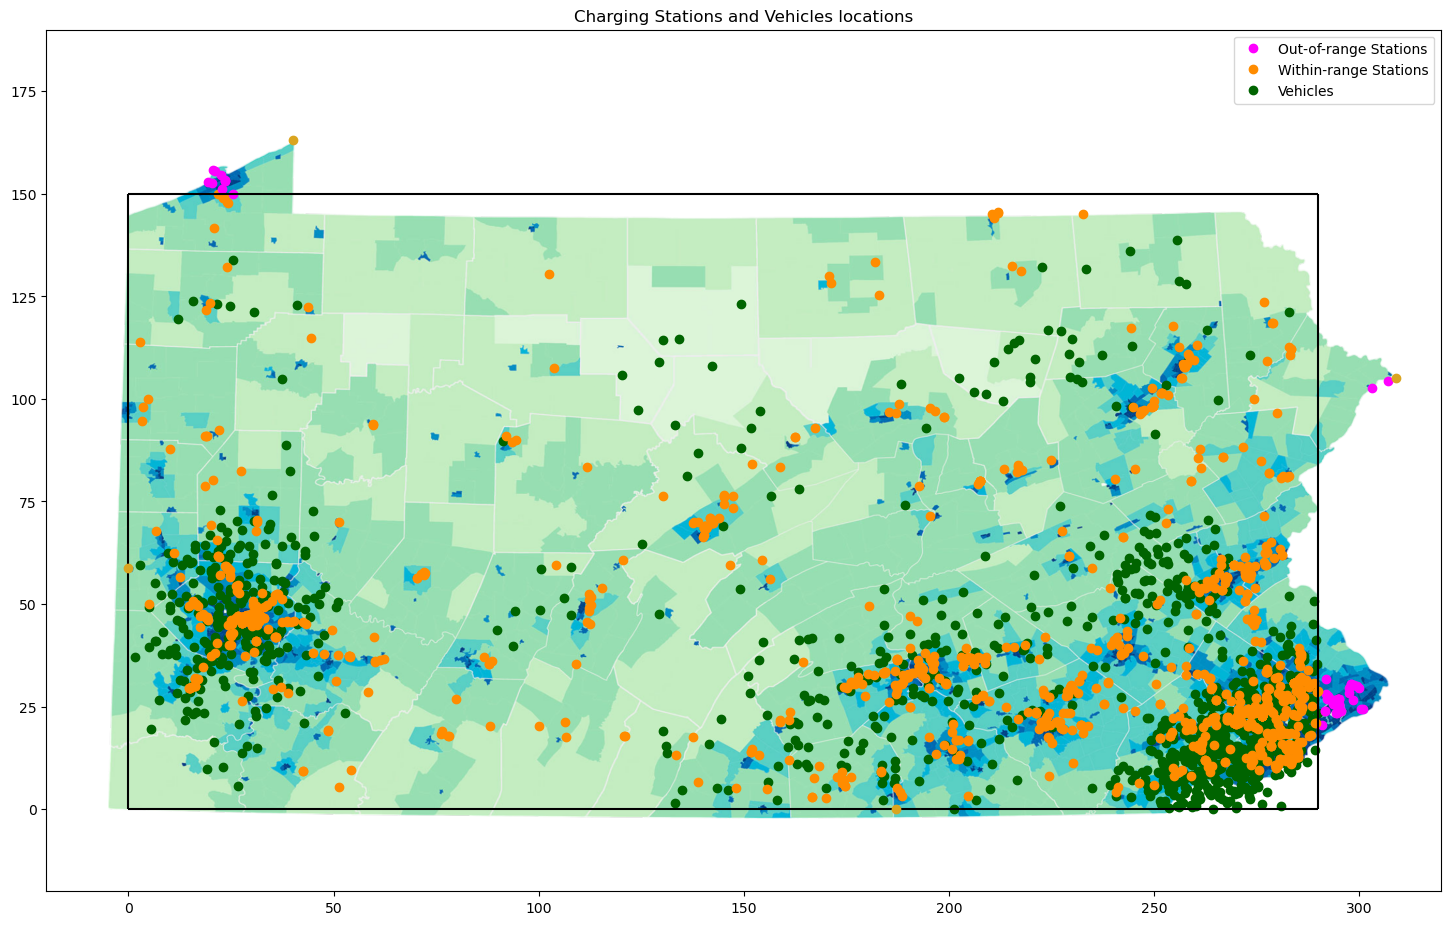

In [4]:
img = plt.imread("./Problem Visualization/Pennsylvania_Population.png")
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))


for v in coor.index:
        x_v = coor.loc[v,0]; y_v = coor.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="darkgreen")

oor = 0
for v in stations.index:
        x_v = stations_loc.loc[v,"Longitude"]; y_v = stations_loc.loc[v,"Latitude"]
        if x_v > 290 or y_v > 150: col= "magenta"; oor += 1
        else: col = "darkorange"
        ax.plot(x_v,y_v,marker="o",color=col)

ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

ax.plot((southern[0]-western[0])*53,0,marker="o",color="goldenrod")
ax.plot((northern[0]-western[0])*53,(northern[1]-southern[1])*69*165/178,marker="o",color="goldenrod")
ax.plot(0,(western[1]-southern[1])*69*165/178,marker="o",color="goldenrod")
ax.plot((eastern[0]-western[0])*53,(eastern[1]-southern[1])*69*165/178,marker="o",color="goldenrod")

ax.plot(-30,-30,marker="o",linestyle="",color="magenta",label="Out-of-range Stations")
ax.plot(-30,-30,marker="o",linestyle="",color="darkorange",label="Within-range Stations")
ax.plot(-30,-30,marker="o",linestyle="",color="darkgreen",label="Vehicles")

#ax.imshow(img, extent=[-5, 308, -5, 178])
ax.imshow(img, extent=[-5, 308, -5, 165])
ax.legend(loc="upper right")
ax.set_xlim(-20,320)
ax.set_ylim(-20,190)
ax.set_title("Charging Stations and Vehicles locations")

print(f"{oor} Out-of-range Stations")

In [5]:
def feasibility_vehic_to_locations(df_vehic,v,r, df_loc):
    distances = [euclidean((df_vehic.loc[v,0], df_vehic.loc[v,1]), (df_loc.loc[l,0], df_loc.loc[l,1])) for l in range(1,df_loc.shape[0]+1)]
    return sum([1 if r/d >= 1 else 0 for d in distances])


def distance_matrix(df1, df2):
    # Extract the x and y coordinates as arrays
    x1 = np.array(df1[0])
    y1 = np.array(df1[1])
    x2 = np.array(df2[0])
    y2 = np.array(df2[1])
    
    # Compute the pairwise distances between the two sets of points
    distances = cdist(np.column_stack((x1, y1)), np.column_stack((x2, y2)))
    
    # Convert the distance matrix to a dictionary
    distance_dict = {}
    for i in range(1,len(df1)+1):
        for j in range(1,len(df2)+1):
            location1 = i
            location2 = j
            distance = distances[i-1,j-1]
            distance_dict[(location1, location2)] = round(distance,2)
            
    return distance_dict

In [6]:
def scheduling(y,V,S,T,p,k,a,r,d,cd,cc,df_vehic,FIFO=0,output=0,write=0,relaxed=0):

    def feas(v,s):
        return d[v,s]<=r[v] and a[v,s]+k[v,s]-1<=T[-1] and a[v,s]<=T[-1]

    m = Model("Scheduling")

    # Auxiliar feasibility variable
    z = {(v,0):m.addVar(name=f"z_{v,0}",vtype=GRB.BINARY) for v in V}
    S_v = {v:[s for s in S if d[v,s]<=r[v]] for v in V}
    w, q, g = {}, {}, {}
    for s in S:
        for v in V:
            # If v \in V is assigned to s \in S
            z[v,s] = m.addVar(name=f"z_{v,s}",vtype=GRB.BINARY)
            for t in T:
                if t >= a[v,s]:
                    # If v \in V starts charging on s \in S at t \in T
                    w[v,s,t] = m.addVar(name=f"w_{v,s,t}",vtype=GRB.BINARY)
                    # If v \in V is charging on s \in S at t \in T
                    q[v,s,t] = m.addVar(name=f"q_{v,s,t}",vtype=GRB.BINARY)
                    # If v \in V is waiting in line on s \in S at t \in T
                    g[v,s,t] = m.addVar(name=f"g_{v,s,t}",vtype=GRB.BINARY)

    # Each vehicle must be assigned to one station
    for v in V:
            m.addConstr(quicksum(z[v,s] for s in S+[0]) == 1)
    
    for s in S:

        for t in T:
            # In every station, at every time period, at most y_s vehicles recharging
            m.addConstr(quicksum(q[v,s,t] for v in V if t >= a[v,s]) <= y[s])
            # In every station, at every time period, at most y_s vehicles waiting in line
            m.addConstr(quicksum(g[v,s,t] for v in V if t >= a[v,s]) <= y[s])

        if FIFO:
            for v1 in V:
                for v2 in V:
                    if a[v1,s] < a[v2,s]:
                        m.addConstr(quicksum(t*w[v1,s,t] for t in T if t >= a[v1,s]) - T[-1]*(1-z[v1,s]) <= quicksum(t*w[v2,s,t] for t in T if t >= a[v2,s]) + T[-1]*(1-z[v2,s]))
        
        for v in V:
            # Vehicle v \in V can only be assigned to a station for which it has enough available range
            m.addConstr(d[v,s]*z[v,s] <= r[v])
            # If assigned to s \in S, v \in V must start to recharge once
            m.addConstr(z[v,s] == quicksum(w[v,s,t] for t in T if t>=a[v,s]))
            # If assigned, must recharge for k_vs periods
            m.addConstr(quicksum(q[v,s,t] for t in T if t >= a[v,s]) == k[v,s]*z[v,s])
            for t in T:
                if t >= a[v,s]:
                    # A vehicle can either be recharging or waiting in line
                    m.addConstr(q[v,s,t] + g[v,s,t] <= 1)
                    if t + k[v,s] - 1 > T[-1]:
                        # Consecutive recharging constraint
                        m.addConstr(w[v,s,t] == 0)
                    else:
                        m.addConstr(quicksum(q[v,s,i] for i in range(t,t+k[v,s])) >= k[v,s]*w[v,s,t])
                    
                if t >= a[v,s] + 1:
                    # The vehicle must be waiting in line before it starts to recharge
                    m.addConstr(quicksum(g[v,s,i] for i in range(a[v,s],t)) >= (t-a[v,s])*w[v,s,t])

        
                    
    
    m.setObjective(quicksum(cd*d[v,s]*z[v,s] for v in V for s in S) + quicksum(cc*p[v,s]*z[v,s] for v in V for s in S)+quicksum(250*(cd+cc)*z[v,0] for v in V)+quicksum(g[v,s,t] for v in V for s in S for t in T if t >= a[v,s]))

    m.update()
    m.optimize()
    m.setParam("OutputFlag",output)

    if write:
        A = m.getA()
        denseMatrix = pd.DataFrame(data=csr_matrix.todense(A))
        denseMatrix.to_csv("./Amatrix.csv", index=False)

    if m.status == 2:

        sub_V = {s:[]}
        for s in S:
            w_s = {v:sum(t*round(w[v,s,t].X) for t in T if t >= a[v,s]) for v in V if z[v,s].X > 0.5}
            sub_V[s] = sorted(w_s, key=lambda v: w_s[v])

        stations = {s:{v:({t:q[v,s,t].X for t in T if t >= a[v,s]},{t:g[v,s,t].X for t in T if t >= a[v,s]}) for v in sub_V[s]} for s in S}
        infeasible = [v for v in V if z[v,0].X > 0.5]
        stats = []
        for v in V:
            if z[v,0].X > 0.5:
                stats.append(0)
            else:
                stats.append([s for s in S if z[v,s].X > 0.5][0])
        df_vehic["station"] = stats
    else:
        stations = print("Infeasible")

    return stations, infeasible, m.getObjective().getValue(), df_vehic

In [7]:
def plot_scheduling_s(s):
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,0.4*len(stations[s])))
    col_charg = "forestgreen"; col_queue = "turquoise"; col_arriv = "darkorange"

    sub_V = list(stations[s].keys()); i = 0
    for v in stations[s]:
        for t in T:
            if t >= a[v,s]:
                if round(stations[s][v][0][t]) == 1:
                    ax.plot(t,i,marker="s",color=col_charg,markersize=9)
                if round(stations[s][v][1][t]) == 1:
                    ax.plot(t,i,marker="s",color=col_queue,markersize=9)
        ax.plot(a[v,s],i,marker="D",color=col_arriv)
        i += 1

    for t in T:
        util = int(round(sum(stations[s][v][0][t] for v in stations[s] if t >= a[v,s])))
        if util == y[s]: col = "red";
        else: col = col_charg
        if util > 0:
            ax.text(x=t,y=-1,s=util, color=col, va="center",ha="center")

        util = int(round(sum(stations[s][v][1][t] for v in stations[s] if t >= a[v,s])))
        if util == y[s]: col = "red";
        else: col = col_queue
        if util > 0:    
            ax.text(x=t,y=-1.5,s=util, color=col, va="center",ha="center")

    ax.plot(-1,-1,marker="D",color=col_arriv,label="arrival",linestyle="")
    ax.plot(-1,-1,marker="s",color=col_queue,markersize=9,label="waiting",linestyle="")
    ax.plot(-1,-1,marker="s",color=col_charg,markersize=9,label="charging",linestyle="")

    ax.text(x=T[-1]+1,y=len(stations[s])/2,s=f"Station {s}\nAssigned vehicles: {len(stations[s])}")

    ax.set_xlim(0.5,T[-1]+0.5); ax.set_xlabel("time period")
    ax.set_ylim(-0.5,len(stations[s])-0.5); ax.set_ylabel("vehicle")

    ax.set_xticks(T); ax.set_xticklabels(T)
    ax.set_xticks([t+0.5 for t in T],minor=True); ax.set_xticklabels([],minor=True)

    ax.set_yticks(range(len(sub_V))); ax.set_yticklabels([f"v{v}" for v in sub_V])
    ax.set_yticks([v+0.5 for v in range(len(sub_V))],minor=True); ax.set_yticklabels([],minor=True)

    ax.legend(bbox_to_anchor=(1.1, 1))

    ax.invert_yaxis()
    ax.grid(which="minor")

def plot_map(df_vehic,df_loc):
    img = plt.imread("./Pennsylvania-County-Map.jpg")
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

    cols = {1:"deeppink", 2:"cyan", 3:"orange", 4:"lime"}

    for v in df_vehic.index:
        s_v = df_vehic.loc[v,"station"]
        x_v = df_vehic.loc[v,0]; y_v = df_vehic.loc[v,1]
        if s_v != 0:
            x_l = df_loc.loc[s_v,0]; y_l = df_loc.loc[s_v,1]
            ax.plot([x_v,x_l],[y_v,y_l], marker="o", color=cols[s_v], linestyle="-")
        else:
            ax.plot(x_v,y_v,marker="o",color="red")

    for l in df_loc.index:
        ax.text(x=df_loc.loc[l,0]-1,y=df_loc.loc[l,1]-5,s=l,color=cols[l],fontsize=10)

    ax.imshow(img, extent=[-10, 305, -20, 165])
    ax.set_title("Vehicle's locations")

In [61]:
def chorizo_maker(S,V,T,d,r,a,k,y):

    def feas(v,s):
        return d[v,s]<=r[v] and a[v,s]+k[v,s]-1<=T[-1] and a[v,s]<=T[-1]

    np.random.seed(0)
    per_stat = int((len(S)+len(V))/len(S))+1
    vertices = {}
    # Un chorizo por cada vehículo
    for s in S:
        vertices[s] = {}
        feas_veh = [v for v in V if feas(v,s)]
        for i in range(per_stat):
            rand_vehic = list(np.random.choice(feas_veh,min(y[s],len(feas_veh))))
            vertices[s][i] = {v:1 if v in rand_vehic else 0 for v in V}
            vertices[s][i].update({(v,t):0 for v in V for t in T if t >= a[v,s]})

    return vertices

def master_problem(S,V,T,a,d,r,vertices,costs,output=0,write=0,integer=0):

    Q = {s:range(len(vertices[s])) for s in S}
    A0 = {s:{v:{u:1 if ((v == u) and (d[u,s] <= r[u])) else 0 for u in V} for v in V} for s in S}

    p_q = {s:{q:{v:sum(A0[s][v][u]*vertices[s][q][u] for u in V) for v in V} for q in Q[s]} for s in S}
    f_q = {s:{q:sum(costs[s][v]*vertices[s][q][v] for v in V)+sum(vertices[s][q][v,t] for v in V for t in T if t >= a[v,s]) for q in Q[s]} for s in S}

    m = Model("Restricted Master Problem")

    if integer == 1: nat = GRB.BINARY
    else: nat = GRB.CONTINUOUS

    lbd = {s:{q:m.addVar(name=f"lambda_{s,q}",vtype=nat) for q in Q[s]} for s in S}
    slack = {v:m.addVar(name=f"slack_{v}",vtype=nat) for v in V}

    for v in V:
        m.addConstr(quicksum(p_q[s][q][v]*lbd[s][q] for s in S for q in Q[s]) + slack[v] == 1, f"V{v}_assignment")

    for s in S:
        m.addConstr(quicksum(lbd[s][q] for q in Q[s]) == 1, f"S{s}_convexity")
    
    m.setObjective(quicksum(f_q[s][q]*lbd[s][q] for s in S for q in Q[s])+quicksum(250*(0.041+0.0388)*slack[v] for v in V))

    m.update()
    m.setParam("OutputFlag",output)
    m.optimize()

    z = {(v,s):sum(vertices[s][q][v]*lbd[s][q].X for q in Q[s]) for v in V for s in S}
    infeasible = [v for v in V if slack[v].X > 0]

    pi_0 = {}
    if integer == 0:
        for v in V:
            cons = m.getConstrByName(f"V{v}_assignment")
            pi_0[f"V{v}"] = cons.getAttr("Pi")
        for s in S:
            cons = m.getConstrByName(f"S{s}_convexity")
            pi_0[f"S{s}"] = cons.getAttr("Pi")
    
    if write:
        A = m.getA()
        denseMatrix = pd.DataFrame(data=csr_matrix.todense(A))
        denseMatrix.to_csv("./Amatrix_MP.csv", index=False)

    return pi_0,infeasible,m.getObjective().getValue(),z


def auxiliary_problem(s,V,T,y,pi,costs,a,d,r,k,output=0):

    m = Model("Auxiliary Problem")

    z = {v:m.addVar(name=f"z_{v}",vtype=GRB.BINARY) for v in V}
    g = {(v,t):m.addVar(name=f"g_{v,t}",vtype=GRB.BINARY) for v in V for t in T if t >= a[v,s]}
    q = {(v,t):m.addVar(name=f"q_{v,t}",vtype=GRB.BINARY) for v in V for t in T if t >= a[v,s]}
    w = {(v,t):m.addVar(name=f"w_{v,t}",vtype=GRB.BINARY) for v in V for t in T if t >= a[v,s]}

    for t in T:

            # In every station, at every time period, at most y_s vehicles recharging
            m.addConstr(quicksum(q[v,t] for v in V if t >= a[v,s]) <= y[s])
            # In every station, at every time period, at most y_s vehicles waiting in line
            m.addConstr(quicksum(g[v,t] for v in V if t >= a[v,s]) <= y[s])

            for v1 in V:
                for v2 in V:
                    if a[v1,s] < a[v2,s]:
                        m.addConstr(quicksum(t*w[v1,t] for t in T if t >= a[v1,s]) - T[-1]*(1-z[v1]) <= quicksum(t*w[v2,t] for t in T if t >= a[v2,s]) + T[-1]*(1-z[v2]))
            
            for v in V:
                # Vehicle v \in V can only be assigned to a station for which it has enough available range
                m.addConstr(d[v,s]*z[v] <= r[v])
                # If assigned to s \in S, v \in V must start to recharge once
                m.addConstr(z[v] == quicksum(w[v,t] for t in T if t>=a[v,s]))
                # If assigned, must recharge for k_vs periods
                m.addConstr(quicksum(q[v,t] for t in T if t >= a[v,s]) == k[v,s]*z[v])
                for t in T:
                    if t >= a[v,s]:
                        # A vehicle can either be recharging or waiting in line
                        m.addConstr(q[v,t] + g[v,t] <= 1)
                        if t + k[v,s] - 1 > T[-1]:
                            # Consecutive recharging constraint
                            m.addConstr(w[v,t] == 0)
                        else:
                            m.addConstr(quicksum(q[v,i] for i in range(t,t+k[v,s])) >= k[v,s]*w[v,t])
                        
                    if t >= a[v,s] + 1:
                        # The vehicle must be waiting in line before it starts to recharge
                        m.addConstr(quicksum(g[v,i] for i in range(a[v,s],t)) >= (t-a[v,s])*w[v,t])


    cost_mod = {v:costs[s][v]-pi[f"V{v}"] if d[v,s] <= r[v] else costs[s][v] for v in V}
    m.setObjective(quicksum(cost_mod[v]*z[v] for v in V) + quicksum(g[v,t] for v in V for t in T if t>=a[v,s]) - pi[f"S{s}"])

    m.update()
    m.setParam("OutputFlag",output)
    m.optimize()

    z = {v:z[v].X for v in V}
    g = {(v,t):g[v,t].X for v in V for t in T if t >= a[v,s]}

    rq = m.getObjective().getValue()

    if rq >= 0: opt = 1
    else: opt = 0

    return opt, z, g

def second_stage_DW(S,V,T,y,cd,cc,a,d,r,p,k):

    optimal = False; i = 0

    vertices = chorizo_maker(S,V,T,d,r,a,k,y)
    costs_z = {s:{v:cd*d[v,s]+cc*p[v,s] if d[v,s] <= r[v] else 270*(cd+cc) for v in V} for s in S}
    objs = []; exist = len(vertices[1])
    while not optimal:
        i += 1

        pi, infeasible, objMP,zz = master_problem(S,V,T,a,d,r,vertices,costs_z)
        print(f"Iteration {i}:\n{sum([1 for v in infeasible])} vehicles\tMP obj: {round(objMP,2)}")
        
        opt = {}
        for s in S:
            opt[s], z, g = auxiliary_problem(s,V,T,y,pi,costs_z,a,d,r,k)
            vertices[s][exist+i-1] = z
            vertices[s][exist+i-1].update(g)

        if sum(opt.values()) == len(S): optimal = True
        else: objs.append(objMP)
    
    pi, infeasible, objMP, zz = master_problem(S,V,T,a,d,r,vertices,costs_z,integer = 1)

    return infeasible, objMP, zz, objs
    

In [13]:
V = list(range(1,51))
S = list(range(1,5))


''' Feasible instance creation '''
indices = random.sample(range(len(coor)), len(S))
sample_loc = coor.iloc[indices]
sample_loc.index = np.arange(1, len(sample_loc) + 1)
coor.drop(coor.index[indices],inplace=True)
coor.reset_index(drop=True, inplace=True)

loc, scale, min_v, max_v= 100, 50, 20, 250
a, b = (min_v - loc) / scale, (max_v - loc) / scale

feasible = 0; sample_vehic = pd.DataFrame({0:[], 1:[], "range":[]})
while feasible < len(V):
    index = random.randint(0,coor.shape[0]-1)
    range_real = truncnorm.rvs(a = a, b = b, loc = loc, scale = scale, size = 1)
    if feasibility_vehic_to_locations(coor,index,range_real,sample_loc) > 3:
        feasible += 1
        sample_vehic = pd.concat([sample_vehic,pd.DataFrame({0:coor.loc[index,0], 1:coor.loc[index,1], "range":[range_real]},index=[0])])
        sample_vehic.index = np.arange(1, len(sample_vehic) + 1)
        coor.drop(coor.index[index],inplace=True)
        coor.reset_index(drop=True, inplace=True)

driving_speed = 75 # miles per hour
steps_per_hour = 6 # each time step is ten minutes
charging_speed = 75*12/7 # miles per hour
T = list(range(1,int(steps_per_hour*2.5)+1))

d = distance_matrix(sample_vehic,sample_loc)
r = {v:sample_vehic.loc[v,"range"][0] for v in V}
p = {(v,s):250-(r[v]-d[v,s]) for v in V for s in S}
a = {(v,s):int(d[v,s]*steps_per_hour/driving_speed)+1 for v in V for s in S}
k = {(v,s):int(p[v,s]*steps_per_hour/charging_speed)+1 for v in V for s in S}
y = {s:6 for s in S}
cf = 5500
cd = 0.041
cc = 0.0388

In [45]:
stations, infeasible, objScheduling, sample_vehic = scheduling(y,V,S,T,p,k,a,r,d,cd,cc,sample_vehic,FIFO=1,output=1)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9895 rows, 5107 columns and 104913 nonzeros
Model fingerprint: 0xfa405849
Variable types: 0 continuous, 5107 integer (5107 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [6e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 997.5000000
Presolve removed 6098 rows and 2842 columns
Presolve time: 0.22s
Presolved: 3797 rows, 2265 columns, 28614 nonzeros
Variable types: 0 continuous, 2265 integer (2265 binary)
Found heuristic solution: objective 785.8298298

Root relaxation: objective 3.274843e+02, 1688 iterations, 0.04 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | 

In [39]:
infeasibleMP, objMP, z, objs = second_stage_DW(S,V,T,y,cd,cc,a,d,r,p,k)

Iteration 1:
46 vehicles	MP obj: 926.49
Iteration 2:
40 vehicles	MP obj: 838.59
Iteration 3:
22 vehicles	MP obj: 587.22
Iteration 4:
22 vehicles	MP obj: 587.22
Iteration 5:
22 vehicles	MP obj: 587.22
Iteration 6:
22 vehicles	MP obj: 587.22
Iteration 7:
22 vehicles	MP obj: 535.52
Iteration 8:
29 vehicles	MP obj: 535.52
Iteration 9:
25 vehicles	MP obj: 520.45
Iteration 10:
28 vehicles	MP obj: 516.25
Iteration 11:
24 vehicles	MP obj: 507.17
Iteration 12:
24 vehicles	MP obj: 500.27
Iteration 13:
22 vehicles	MP obj: 493.08
Iteration 14:
24 vehicles	MP obj: 477.23
Iteration 15:
23 vehicles	MP obj: 472.01
Iteration 16:
24 vehicles	MP obj: 459.64
Iteration 17:
23 vehicles	MP obj: 452.79
Iteration 18:
20 vehicles	MP obj: 445.97
Iteration 19:
17 vehicles	MP obj: 434.99
Iteration 20:
14 vehicles	MP obj: 422.91
Iteration 21:
18 vehicles	MP obj: 419.81
Iteration 22:
13 vehicles	MP obj: 416.17
Iteration 23:
13 vehicles	MP obj: 413.62
Iteration 24:
13 vehicles	MP obj: 411.03
Iteration 25:
13 vehicles

In [19]:
infeasible, objScheduling

([10, 19, 23, 44], 371.5437952794743)

In [40]:
infeasibleMP,objMP

([10, 19, 23, 30], 375.6605121503477)

Text(0, 0.5, 'Z')

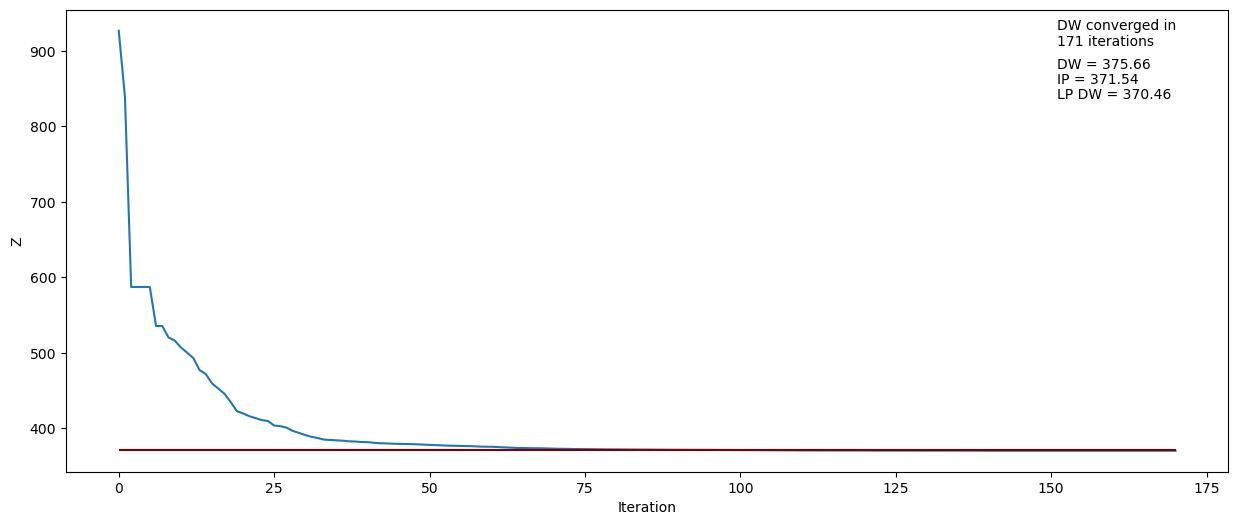

In [44]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,6))


ax.plot(objs,label="LP DW")
ax.hlines(y=objScheduling,xmin=0,xmax=len(objs)-1,color="maroon",label="IP")

ax.text(x=len(objs)-20,y=max(objs)-20,s=f"DW converged in\n{len(objs)} iterations")

ax.text(x=len(objs)-20,y=max(objs)-50,s=f"DW = {round(objMP,2)}")
ax.text(x=len(objs)-20,y=max(objs)-70,s=f"IP = {round(objScheduling,2)}")
ax.text(x=len(objs)-20,y=max(objs)-90,s=f"LP DW = {round(objs[-1],2)}")

ax.set_xlabel("Iteration")
ax.set_ylabel("Z")


In [62]:
infeasibleMP, objMP, z, objs = second_stage_DW(S,V,T,y,cd,cc,a,d,r,p,k)

Iteration 1:
36 vehicles	MP obj: 664.22
Iteration 2:
29 vehicles	MP obj: 527.9
Iteration 3:
26 vehicles	MP obj: 491.18
Iteration 4:
23 vehicles	MP obj: 478.05
Iteration 5:
21 vehicles	MP obj: 474.16
Iteration 6:
19 vehicles	MP obj: 464.26
Iteration 7:
20 vehicles	MP obj: 455.93
Iteration 8:
20 vehicles	MP obj: 447.41
Iteration 9:
16 vehicles	MP obj: 441.42
Iteration 10:
14 vehicles	MP obj: 434.9
Iteration 11:
14 vehicles	MP obj: 429.7
Iteration 12:
16 vehicles	MP obj: 425.06
Iteration 13:
11 vehicles	MP obj: 419.11
Iteration 14:
12 vehicles	MP obj: 414.8
Iteration 15:
12 vehicles	MP obj: 411.75
Iteration 16:
11 vehicles	MP obj: 406.56
Iteration 17:
13 vehicles	MP obj: 401.43
Iteration 18:
11 vehicles	MP obj: 396.71
Iteration 19:
15 vehicles	MP obj: 394.39
Iteration 20:
13 vehicles	MP obj: 393.43
Iteration 21:
15 vehicles	MP obj: 392.77
Iteration 22:
14 vehicles	MP obj: 392.22
Iteration 23:
13 vehicles	MP obj: 390.74
Iteration 24:
9 vehicles	MP obj: 390.25
Iteration 25:
9 vehicles	MP ob

Text(0, 0.5, 'Z')

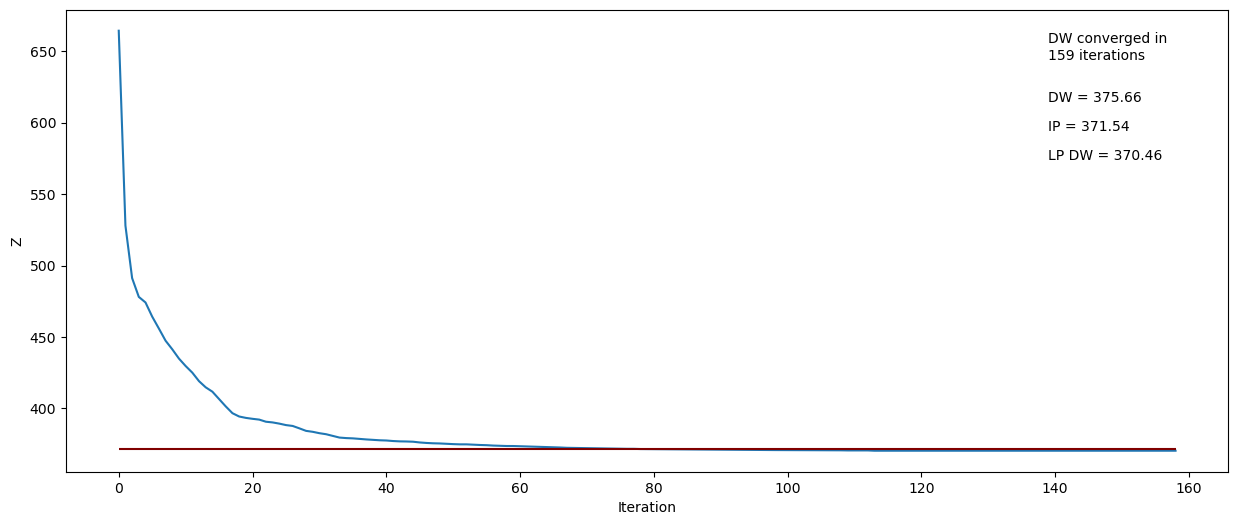

In [63]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,6))


ax.plot(objs,label="LP DW")
ax.hlines(y=objScheduling,xmin=0,xmax=len(objs)-1,color="maroon",label="IP")

ax.text(x=len(objs)-20,y=max(objs)-20,s=f"DW converged in\n{len(objs)} iterations")

ax.text(x=len(objs)-20,y=max(objs)-50,s=f"DW = {round(objMP,2)}")
ax.text(x=len(objs)-20,y=max(objs)-70,s=f"IP = {round(objScheduling,2)}")
ax.text(x=len(objs)-20,y=max(objs)-90,s=f"LP DW = {round(objs[-1],2)}")

ax.set_xlabel("Iteration")
ax.set_ylabel("Z")